# specage Example: Peak Fitting
This example demonstrates how to use the pkfit module of specage. The data used are spectra recorded by OceanOptics HR2000+ spectrometer. matplotlib and numpy are needed. The peak fitting module currently supports gaussian and lorentzian peak shapes as well as linear baselines. If needed additional functions can be easily implemented individually or upon request.


## Step 0: Preamble

Import the necessary modules, to create a working environment:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

From specage the specific reader function is needed as well as the peakfit module:

In [2]:
from specage.ov_readers import spectra_time_series as read_ts
from specage.spcl import TimeSeries as tseries
import specage.pkfit as pkfit

## Step 1: Load & Inspect the Data

First, read ASCII data by using the reader for OceanOptics Spectra and create the TimeSeries Object *ts*

In [3]:
Filepath = './/example_data//'
Filename = 'examplesTS.txt'

ts = read_ts(Filepath+Filename);

*ts* contains all spectra and their recording times as Spectrum objects. 

Now, we inspect the full data set: 

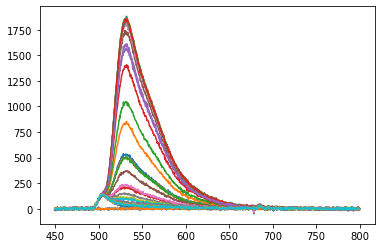

In [4]:
plt.plot(ts.x, ts.intarray);

Select and plot a specific spectrum (*AniceSpectrum*):

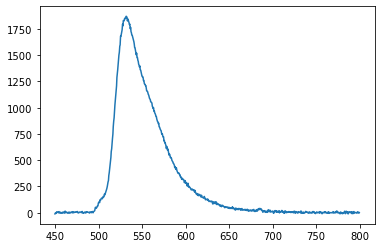

In [5]:
AniceSpectrum = ts[29]

plt.plot(AniceSpectrum.x, AniceSpectrum.intensity);

## Step 2: Peak fitting

First, some input parameters mus be defined, starting with the model which is defined by a list of functions that are provided in pkfit. The model can contain any number of individual functions. Furthermor the x-range is defined:

In [6]:
model = [
         pkfit.lin,             # a linear baseline
         pkfit.gaussarea,       # a gaussian peak with the area as parameter
         pkfit.lorentzarea,     # a lorentzian peak with the area as parameter
         ]
xrange = np.array([503,680])

The linear baseline function pkfit.lin has 2 parameters: 
1. y-intercept 
2. slope.

The peakfunctions have 3 parameters: 
1. size (peak height(amplitude) or area)
2. x-position 
3. width

These informations are important for model creation can be found in the doc of each function. *help(function)*

For fitting, initial starting values must be defined for all parameters in a numpy array of length \[n,\] and "dtype=object", with n being the sum of the number of all parameters. For example for the model defined above n = 8. 

Fitting parameters are defined as special variables of the pkfit.singlepar class whose value is the initial starting value. They contain also their lower and upper bounds the respective keyword arguments "lb" and "ub" default to -inf and inf. 

Fixed parameters are defined by any numeric type:

In [7]:
n = pkfit.singlepar(0, lb=-50, ub=500)   # this is a fit parameter
m = 0                                    # this parameter is fixed

a1 = pkfit.singlepar(1000, lb=0)
x1 = pkfit.singlepar(525, lb=500, ub=550)
w1 = pkfit.singlepar(25, lb=5, ub=100)

a2 = pkfit.singlepar(3000, lb=0)
x2 = pkfit.singlepar(560, lb =550, ub=650)
w2 = pkfit.singlepar(25, lb=5, ub=100)

initpara = np.array([ 
                     n ,   m,       # y-intercept, slope,     --> pkfit.lin
                     a1, x1, w1,    # area1, x-pos1, width1,  --> pkfit.gaussarea
                     a2, x2, w2,    # area2, x-pos2, width2,  --> pkfit.lorentzarea
                     ], dtype=object)
    

Now, the fitpeak function is called to fit the peak and all the parameters defined above are passed. The console output can be controlled by the 'verbose' keyword argument. verbose = 2 shows all progress and indicates the success of the fitting routine.

In [8]:
res, err = pkfit.fitpeak(AniceSpectrum, 
                         initpara, 
                         model, 
                         xrange = xrange,
                         verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1778e+08                                    1.05e+08    
       1              2         6.8986e+07      4.88e+07       3.18e+03       2.61e+07    
       2              3         4.6926e+07      2.21e+07       6.34e+03       2.16e+07    
       3              4         3.3015e+07      1.39e+07       1.27e+04       3.52e+07    
       4              5         1.9546e+07      1.35e+07       1.27e+04       6.07e+07    
       5              6         7.3906e+06      1.22e+07       2.19e+04       1.05e+07    
       6             14         5.7895e+06      1.60e+06       8.88e+00       7.65e+06    
       7             15         4.7402e+06      1.05e+06       2.23e+01       1.76e+07    
       8             16         1.7125e+06      3.03e+06       1.74e+01       2.12e+06    
       9             17         1.6253e+06      8.72e+04       6.94e+00       6.91e+05    

## Step 3: Plot and Inspect the Results

Plot the peak and the fitted spectra, which are now all accessible via the Spectrum object *AniceSpectrum*

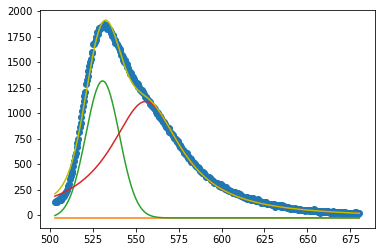

In [9]:
# plot the data
plt.plot(AniceSpectrum.get_peak()[:,0], AniceSpectrum.get_peak()[:,1],'o');

# plot the fitted baseline
plt.plot(AniceSpectrum.get_peak()[:,0], AniceSpectrum.fittedpeaks.intarray[:,0]);

# plot the fitted peaks on the baseline
plt.plot(AniceSpectrum.get_peak()[:,0], (AniceSpectrum.fittedpeaks.intarray[:,1:].T + AniceSpectrum.fittedpeaks.intarray[:,0]).T);

# plot the sum of peaks+baseline
plt.plot(AniceSpectrum.get_peak()[:,0], np.sum(AniceSpectrum.fittedpeaks.intarray, axis=1), color='y');

Many results of the fitting routine are now available via *AniceSpectrum.fitresults* for instance the final parameters:

In [10]:
with np.printoptions(precision=5, suppress = True):
        print(AniceSpectrum.fitresults.parameters)

[-25.798074431662215 0 32846.72763757781 530.7535565612084
 23.005670014345405 90671.13464870637 555.8676809055901 50.62008453446282]


The results will most probably not be perfect in the first try, so go back to Step 2 and start playing with the parameters.

## Advanced Level I: How to fit multiple spectra of Series

The peakfit.fitpeak() function can also be used to fit all spectra of a series for this it is applied to the SpectralSeries or TimeSeries objects:

In [11]:
res, err = pkfit.fitpeak(ts, 
                         initpara,  
                         model, 
                         xrange = xrange,
                         verbose=0)

The results can be retrieved by iterating over *ts*. Here we extract the area, positions and widths of the fitted peaks:

In [12]:
fittedpeakareas=np.array([spectr.fitresults.parameters[[2,5]] for spectr in ts])

fittedpeakpositions=np.array([spectr.fitresults.parameters[[3,6]] for spectr in ts])

fittedpeakwidths=np.array([spectr.fitresults.parameters[[4,7]] for spectr in ts])

Then the results can be plotted:

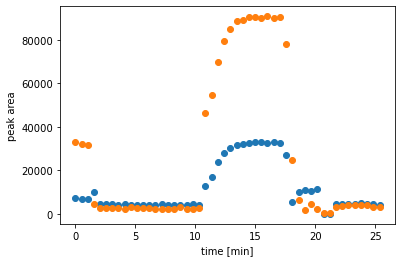

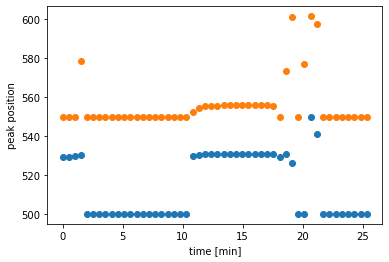

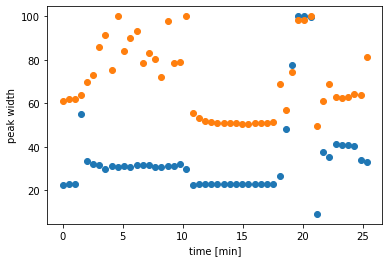

In [13]:
plt.figure()
plt.plot(ts.t_rel/60, fittedpeakareas,'o')
plt.ylabel('peak area')
plt.xlabel('time [min]');

plt.figure()
plt.plot(ts.t_rel/60, fittedpeakpositions,'o')
plt.ylabel('peak position')
plt.xlabel('time [min]');

plt.figure()
plt.plot(ts.t_rel/60, fittedpeakwidths,'o')
plt.ylabel('peak width')
plt.xlabel('time [min]');

## Advanced Level II: How to make global fit of multiple spectra with shared parameters

Now we want to apply a global fit, which means that specific parameters are shared amongst the datasets and/or within one dataset. This calculation can be time consuming for large datasets hence a subset is used here:

In [14]:
ts2 = tseries(ts[21:34])

Now, The shared parameters are redefined:

In [15]:
pkfit.singlepar

n = pkfit.sharedpar(0, lb=-50, ub=500)

x1 = pkfit.sharedpar(525, lb=500, ub=550)

x2 = pkfit.sharedpar(560, lb =550, ub=650)

w1 = pkfit.sharedpar(25, lb=5, ub=100)

w2 = w1

As the other parameters stay single (i.e. unshared) the initial parameters are:

In [16]:
initpara = np.array([ 
                     n ,   m,       # y-intercept, slope,     
                     a1, x1, w1,    # area1, x-pos1, width1,  
                     a2, x2, w1,    # area2, x-pos2, width2 = width1
                     ], dtype=object)

note: if parameters are supposed to be shared within one spectrum it is important that they are identical in initpara. I.e. "initpara\[m\] is initpara\[n\]" returns True, as in:

In [17]:
initpara[4]==initpara[7]

True

For global fitting, the fitpeak function is called with the keyword argument "fitglobal=True". The ftol condition may need to be increased because of the high number of datapoints:

In [18]:
res, er = pkfit.fitpeak(ts, 
                        initpara, 
                        model, 
                        fitglobal=True,
                        xrange = xrange,
                        verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3536e+09                                    1.43e+09    
       1              2         1.1608e+09      1.93e+08       1.44e+04       9.67e+08    
       2              3         1.0424e+09      1.18e+08       9.07e+01       1.32e+08    
       3              4         8.4568e+08      1.97e+08       1.63e+04       1.14e+08    
       4              5         6.8898e+08      1.57e+08       1.60e+04       2.43e+07    
       5              6         4.4092e+08      2.48e+08       3.19e+04       1.79e+07    
       6              7         1.6331e+08      2.78e+08       6.39e+04       2.22e+08    
       7              8         3.3338e+07      1.30e+08       7.12e+04       2.07e+08    
       8              9         2.0626e+07      1.27e+07       2.25e+04       1.57e+08    
       9             10         1.7731e+07      2.89e+06       9.06e+03       7.31e+07    

Plot some of the results:

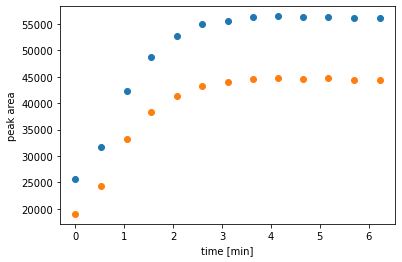

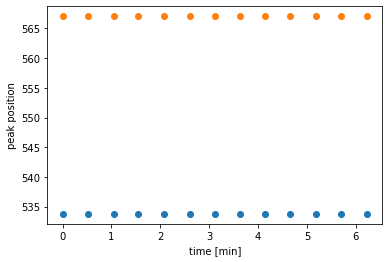

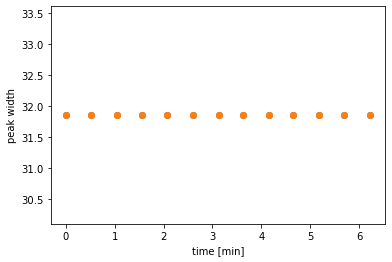

In [19]:
fittedpeakareas=np.array([spectr.fitresults.parameters[[2,5]] 
                            for spectr in ts2])

fittedpeakpositions=np.array([spectr.fitresults.parameters[[3,6]] 
                            for spectr in ts2])

fittedpeakwidths=np.array([spectr.fitresults.parameters[[4,7]] 
                            for spectr in ts2])

plt.figure()
plt.plot(ts2.t_rel/60, fittedpeakareas,'o')
plt.ylabel('peak area')
plt.xlabel('time [min]');

plt.figure()
plt.plot(ts2.t_rel/60, fittedpeakpositions,'o')
plt.ylabel('peak position')
plt.xlabel('time [min]');

plt.figure()
plt.plot(ts2.t_rel/60, fittedpeakwidths,'o')
plt.ylabel('peak width')
plt.xlabel('time [min]');